In [ ]:
import os
import shutil
import requests
import zipfile
from io import BytesIO
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import kagglehub

# Download dataset using kagglehub
print("Downloading dataset using kagglehub...")
path = kagglehub.dataset_download("mikolajbabula/disaster-images-dataset-cnn-model")
print("Path to dataset files:", path)
print("Contents of the dataset folder:", os.listdir(path))

Path to dataset files: /root/.cache/kagglehub/datasets/mikolajbabula/disaster-images-dataset-cnn-model/versions/1
Contents of the dataset folder: ['best_model.h5', 'DisasterModel', 'history']


In [ ]:
# Paths
input_dir = "/root/.cache/kagglehub/datasets/mikolajbabula/disaster-images-dataset-cnn-model/versions/1/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset"
output_dir = "train_Test_Valid"

In [ ]:
# Ratios for splitting
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# Supported file extensions
valid_extensions = {'.jpg', '.jpeg', '.png'}

In [ ]:
# Clean and recreate output directories
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
for split in ['train', 'valid', 'test']:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)


In [ ]:
# Organizing the dataset
for class_folder in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_folder)
    if os.path.isdir(class_path):
        # Collect valid image files
        images = [
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f)) and os.path.splitext(f)[1].lower() in valid_extensions
        ]

        print(f"Class: {class_folder}, Total Files: {len(images)}")

        if not images:
            print(f"Warning: No valid images found in {class_folder}. Skipping...")
            continue

        # Splitting into train, validation, and test
        train_files, test_files = train_test_split(images, test_size=(valid_ratio + test_ratio), random_state=42)
        valid_files, test_files = train_test_split(test_files, test_size=test_ratio / (valid_ratio + test_ratio), random_state=42)

        # Copy files to respective directories
        for split, files in zip(['train', 'valid', 'test'], [train_files, valid_files, test_files]):
            split_class_dir = os.path.join(output_dir, split, class_folder)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in files:
                shutil.copy(os.path.join(class_path, file), os.path.join(split_class_dir, file))
                print(f"Copied {file} to {split_class_dir}")

print("Dataset organized successfully into train, valid, and test folders!")

Class: Flood, Total Files: 1073
Copied 943.jpg to train_Test_Valid/train/Flood
Copied 582.jpg to train_Test_Valid/train/Flood
Copied 885.jpg to train_Test_Valid/train/Flood
Copied 830.jpg to train_Test_Valid/train/Flood
Copied 405.jpg to train_Test_Valid/train/Flood
Copied 288.jpg to train_Test_Valid/train/Flood
Copied 624.jpg to train_Test_Valid/train/Flood
Copied 775.jpg to train_Test_Valid/train/Flood
Copied 867.jpg to train_Test_Valid/train/Flood
Copied 401.jpg to train_Test_Valid/train/Flood
Copied 913.jpg to train_Test_Valid/train/Flood
Copied 426.jpg to train_Test_Valid/train/Flood
Copied 551.jpg to train_Test_Valid/train/Flood
Copied 589.jpg to train_Test_Valid/train/Flood
Copied 838.jpg to train_Test_Valid/train/Flood
Copied 997.jpg to train_Test_Valid/train/Flood
Copied 902.jpg to train_Test_Valid/train/Flood
Copied 487.jpg to train_Test_Valid/train/Flood
Copied 71.jpg to train_Test_Valid/train/Flood
Copied 754.jpg to train_Test_Valid/train/Flood
Copied 432.jpg to train_Test_

In [ ]:
# Verify the distribution
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(output_dir, split)
    print(f"{split.capitalize()} classes:", os.listdir(split_path))
    for class_folder in os.listdir(split_path):
        class_path = os.path.join(split_path, class_folder)
        print(f"Class: {class_folder}, Files: {len(os.listdir(class_path))}")

Train classes: ['Flood', 'Wildfire', 'Earthquake', 'Cyclone']
Class: Flood, Files: 751
Class: Wildfire, Files: 753
Class: Earthquake, Files: 945
Class: Cyclone, Files: 649
Valid classes: ['Flood', 'Wildfire', 'Earthquake', 'Cyclone']
Class: Flood, Files: 161
Class: Wildfire, Files: 162
Class: Earthquake, Files: 202
Class: Cyclone, Files: 139
Test classes: ['Flood', 'Wildfire', 'Earthquake', 'Cyclone']
Class: Flood, Files: 161
Class: Wildfire, Files: 162
Class: Earthquake, Files: 203
Class: Cyclone, Files: 140


In [ ]:
# Data augmentation and preprocessing
train_dir = os.path.join(output_dir, 'train')
valid_dir = os.path.join(output_dir, 'valid')
test_dir = os.path.join(output_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical'
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=(150, 150), batch_size=32, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False
)

Found 3098 images belonging to 4 classes.
Found 664 images belonging to 4 classes.
Found 666 images belonging to 4 classes.


In [ ]:
# Model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # Adjust number of classes if necessary
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.3876 - loss: 1.3703 - val_accuracy: 0.7455 - val_loss: 0.7707
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.7712 - loss: 0.6214 - val_accuracy: 0.7620 - val_loss: 0.6736
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8155 - loss: 0.5189 - val_accuracy: 0.8012 - val_loss: 0.6009
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.8105 - loss: 0.4951 - val_accuracy: 0.7907 - val_loss: 0.6259
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8332 - loss: 0.4437 - val_accuracy: 0.7982 - val_loss: 0.5720
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.8680 - loss: 0.3719 - val_accuracy: 0.8373 - val_loss: 0.4629
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.8695 - loss: 0.3574 - val_accuracy: 0.8283 - val_loss: 0.4980
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.8806 - loss: 0.3258 - val_accuracy: 0.8434 - val_loss: 0.

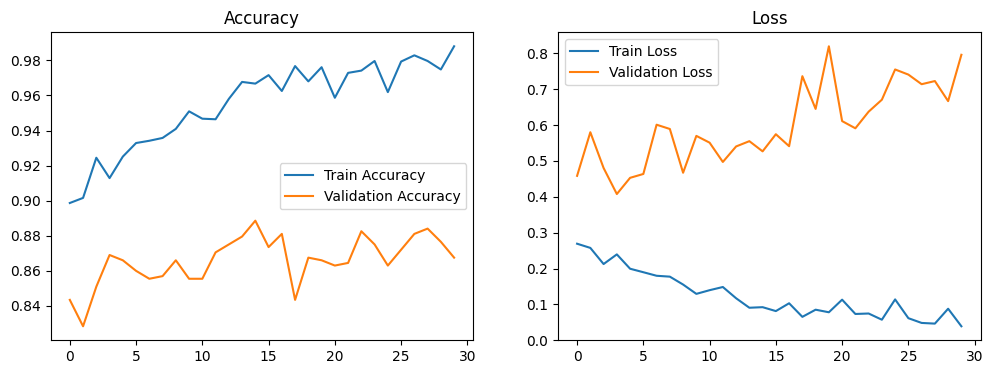

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
# Save the model
model.save('disaster_classifier_model.keras')

In [ ]:
# Classification report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 869ms/step
Classification Report:
              precision    recall  f1-score   support

     Cyclone       0.86      0.96      0.91       140
  Earthquake       0.87      0.88      0.87       203
       Flood       0.84      0.80      0.82       161
    Wildfire       0.93      0.88      0.91       162

    accuracy                           0.88       666
   macro avg       0.88      0.88      0.88       666
weighted avg       0.88      0.88      0.87       666



In [ ]:
# Confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

Confusion Matrix:
[[134   1   2   3]
 [  9 178  11   5]
 [  9  21 128   3]
 [  3   5  11 143]]
